In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import glob
from collections import Counter
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

from scipy.stats import linregress
from skimage.transform import rescale, resize

from PIL import ImageDraw
from matplotlib.colors import ListedColormap

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
BASEDIR = Path("/content/drive/MyDrive/silicanets-data/")

### Load a trained model

In [4]:
model_name = "resnet-strain-variable-2022-02-22T18_24_14"

#df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df.p")
#df_subsampled = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_subsampled.p")
#df_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_train.p")
#df_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_validation.p")
df_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "df_test.p")


#X_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_train.p")
#X_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_validation.p")
X_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "X_test.p")

#y_train = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_train.p")
#y_validation = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_validation.p")
y_test = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "y_test.p")

#history_df = pd.read_pickle(BASEDIR / "output" / model_name / "dataframes" / "history_df.p")

# recover important settings
info = dict(pd.read_csv(BASEDIR / "output" / model_name / "model_info.csv").values)
dropout = float(info["dropout"])
try:
  training_data_disorder_variance = float(info["disorder_variance"])
except:
  training_data_disorder_variance = str(info["disorder_variance"])

In [5]:
premaid = tf.keras.applications.ResNet50(
      include_top = False,
      pooling = "avg",
      weights = None,
      #input_shape=X_train[0].shape,
      input_shape = (128,128,1),
  )


inputs = tf.keras.Input(shape=(128, 128, 1))

resnet = premaid(inputs)
dropout = tf.keras.layers.Dropout(0,name = 'Drop')(resnet) #attenzione che forse è 0 per il nostro modello
outputs = tf.keras.layers.Dense(1,name = 'Output')(dropout)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [6]:
model.load_weights(BASEDIR / "output" / model_name / "checkpoints")

In [8]:
premaid.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

### Grad-CAM implementation


In order to implement Grad-CAM we have followed and customized the keras tutorial at: https://keras.io/examples/vision/grad_cam/

In [9]:
def get_gc_heatmap(model,img_vect):
    
    last_conv_layer = model.get_layer('resnet50').get_layer('conv2_block3_out')
    last_conv_layer_model = tf.keras.Model(model.get_layer('resnet50').inputs, last_conv_layer.output)
    
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])

    x = classifier_input

    xc1 = model.get_layer('resnet50').get_layer('conv3_block1_1_conv')(x)
    xc2 = model.get_layer('resnet50').get_layer('conv3_block1_1_bn')(xc1) 
    xc3 = model.get_layer('resnet50').get_layer('conv3_block1_1_relu')(xc2)
    xc4 = model.get_layer('resnet50').get_layer('conv3_block1_2_conv')(xc3)
    xc5 = model.get_layer('resnet50').get_layer('conv3_block1_2_bn')(xc4)
    xc6 = model.get_layer('resnet50').get_layer('conv3_block1_2_relu')(xc5)
    xc7 = model.get_layer('resnet50').get_layer('conv3_block1_0_conv')(x)
    xc8 = model.get_layer('resnet50').get_layer('conv3_block1_3_conv')(xc6)
    xc9 = model.get_layer('resnet50').get_layer('conv3_block1_0_bn')(xc7)
    xc10 = model.get_layer('resnet50').get_layer('conv3_block1_3_bn')(xc8)
    xc11 = model.get_layer('resnet50').get_layer('conv3_block1_add')([xc9, xc10])
    xc12 = model.get_layer('resnet50').get_layer('conv3_block1_out')(xc11)
    xc13 = model.get_layer('resnet50').get_layer('conv3_block2_1_conv')(xc12)
    xc14 = model.get_layer('resnet50').get_layer('conv3_block2_1_bn')(xc13)
    xc15 = model.get_layer('resnet50').get_layer('conv3_block2_1_relu')(xc14)
    xc16 = model.get_layer('resnet50').get_layer('conv3_block2_2_conv')(xc15)
    xc17 = model.get_layer('resnet50').get_layer('conv3_block2_2_bn')(xc16)
    xc18 = model.get_layer('resnet50').get_layer('conv3_block2_2_relu')(xc17)
    xc19 = model.get_layer('resnet50').get_layer('conv3_block2_3_conv')(xc18)
    xc20 = model.get_layer('resnet50').get_layer('conv3_block2_3_bn')(xc19)
    xc21 = model.get_layer('resnet50').get_layer('conv3_block2_add')([xc12, xc20])
    xc22 = model.get_layer('resnet50').get_layer('conv3_block2_out')(xc21)
    xc23 = model.get_layer('resnet50').get_layer('conv3_block3_1_conv')(xc22)
    xc24 = model.get_layer('resnet50').get_layer('conv3_block3_1_bn')(xc23)
    xc25 = model.get_layer('resnet50').get_layer('conv3_block3_1_relu')(xc24)
    xc26 = model.get_layer('resnet50').get_layer('conv3_block3_2_conv')(xc25)
    xc27 = model.get_layer('resnet50').get_layer('conv3_block3_2_bn')(xc26)
    xc28 = model.get_layer('resnet50').get_layer('conv3_block3_2_relu')(xc27)
    xc29 = model.get_layer('resnet50').get_layer('conv3_block3_3_conv')(xc28)
    xc30 = model.get_layer('resnet50').get_layer('conv3_block3_3_bn')(xc29)
    xc31 = model.get_layer('resnet50').get_layer('conv3_block3_add')([xc22, xc30])
    xc32 = model.get_layer('resnet50').get_layer('conv3_block3_out')(xc31)
    xc33 = model.get_layer('resnet50').get_layer('conv3_block4_1_conv')(xc32)
    xc34 = model.get_layer('resnet50').get_layer('conv3_block4_1_bn')(xc33)
    xc35 = model.get_layer('resnet50').get_layer('conv3_block4_1_relu')(xc34)
    xc36 = model.get_layer('resnet50').get_layer('conv3_block4_2_conv')(xc35)
    xc37 = model.get_layer('resnet50').get_layer('conv3_block4_2_bn')(xc36)
    xc38 = model.get_layer('resnet50').get_layer('conv3_block4_2_relu')(xc37)
    xc39 = model.get_layer('resnet50').get_layer('conv3_block4_3_conv')(xc38)
    xc40 = model.get_layer('resnet50').get_layer('conv3_block4_3_bn')(xc39)
    xc41 = model.get_layer('resnet50').get_layer('conv3_block4_add')([xc32, xc40])
    xc42 = model.get_layer('resnet50').get_layer('conv3_block4_out')(xc41)

    x1 = model.get_layer('resnet50').get_layer('conv4_block1_1_conv')(xc41)
    x2 = model.get_layer('resnet50').get_layer('conv4_block1_1_bn')(x1)
    x3 = model.get_layer('resnet50').get_layer('conv4_block1_1_relu')(x2)
    x4 = model.get_layer('resnet50').get_layer('conv4_block1_2_conv')(x3)
    x5 = model.get_layer('resnet50').get_layer('conv4_block1_2_bn')(x4)
    x6 = model.get_layer('resnet50').get_layer('conv4_block1_2_relu')(x5)
    x7 = model.get_layer('resnet50').get_layer('conv4_block1_0_conv')(xc41)
    x8 = model.get_layer('resnet50').get_layer('conv4_block1_3_conv')(x6)
    x9 = model.get_layer('resnet50').get_layer('conv4_block1_0_bn')(x7)
    x10 = model.get_layer('resnet50').get_layer('conv4_block1_3_bn')(x8)
    x11 = model.get_layer('resnet50').get_layer('conv4_block1_add')([x9, x10])
    x12 = model.get_layer('resnet50').get_layer('conv4_block1_out')(x11)
    x13 = model.get_layer('resnet50').get_layer('conv4_block2_1_conv')(x12)
    x14 = model.get_layer('resnet50').get_layer('conv4_block2_1_bn')(x13)
    x15 = model.get_layer('resnet50').get_layer('conv4_block2_1_relu')(x14)
    x16 = model.get_layer('resnet50').get_layer('conv4_block2_2_conv')(x15)
    x17 = model.get_layer('resnet50').get_layer('conv4_block2_2_bn')(x16)
    x18 = model.get_layer('resnet50').get_layer('conv4_block2_2_relu')(x17)
    x19 = model.get_layer('resnet50').get_layer('conv4_block2_3_conv')(x18)
    x20 = model.get_layer('resnet50').get_layer('conv4_block2_3_bn')(x19)
    x21 = model.get_layer('resnet50').get_layer('conv4_block2_add')([x12, x20])
    x22 = model.get_layer('resnet50').get_layer('conv4_block2_out')(x21)
    x23 = model.get_layer('resnet50').get_layer('conv4_block3_1_conv')(x22)
    x24 = model.get_layer('resnet50').get_layer('conv4_block3_1_bn')(x23)
    x25 = model.get_layer('resnet50').get_layer('conv4_block3_1_relu')(x24)
    x26 = model.get_layer('resnet50').get_layer('conv4_block3_2_conv')(x25)
    x27 = model.get_layer('resnet50').get_layer('conv4_block3_2_bn')(x26)
    x28 = model.get_layer('resnet50').get_layer('conv4_block3_2_relu')(x27)
    x29 = model.get_layer('resnet50').get_layer('conv4_block3_3_conv')(x28)
    x30 = model.get_layer('resnet50').get_layer('conv4_block3_3_bn')(x29)
    x31 = model.get_layer('resnet50').get_layer('conv4_block3_add')([x22, x30])
    x32 = model.get_layer('resnet50').get_layer('conv4_block3_out')(x31)
    x33 = model.get_layer('resnet50').get_layer('conv4_block4_1_conv')(x32)
    x34 = model.get_layer('resnet50').get_layer('conv4_block4_1_bn')(x33)
    x35 = model.get_layer('resnet50').get_layer('conv4_block4_1_relu')(x34)
    x36 = model.get_layer('resnet50').get_layer('conv4_block4_2_conv')(x35)
    x37 = model.get_layer('resnet50').get_layer('conv4_block4_2_bn')(x36)
    x38 = model.get_layer('resnet50').get_layer('conv4_block4_2_relu')(x37)
    x39 = model.get_layer('resnet50').get_layer('conv4_block4_3_conv')(x38)
    x40 = model.get_layer('resnet50').get_layer('conv4_block4_3_bn')(x39)
    x41 = model.get_layer('resnet50').get_layer('conv4_block4_add')([x32, x40])
    x42 = model.get_layer('resnet50').get_layer('conv4_block4_out')(x41)
    x43 = model.get_layer('resnet50').get_layer('conv4_block5_1_conv')(x42)
    x44 = model.get_layer('resnet50').get_layer('conv4_block5_1_bn')(x43)
    x45 = model.get_layer('resnet50').get_layer('conv4_block5_1_relu')(x44)
    x46 = model.get_layer('resnet50').get_layer('conv4_block5_2_conv')(x45)
    x47 = model.get_layer('resnet50').get_layer('conv4_block5_2_bn')(x46)
    x48 = model.get_layer('resnet50').get_layer('conv4_block5_2_relu')(x47)
    x49 = model.get_layer('resnet50').get_layer('conv4_block5_3_conv')(x48)
    x50 = model.get_layer('resnet50').get_layer('conv4_block5_3_bn')(x49)
    x51 = model.get_layer('resnet50').get_layer('conv4_block5_add')([x42, x50])
    x52 = model.get_layer('resnet50').get_layer('conv4_block5_out')(x51)
    x53 = model.get_layer('resnet50').get_layer('conv4_block6_1_conv')(x52)
    x54 = model.get_layer('resnet50').get_layer('conv4_block6_1_bn')(x53)
    x55 = model.get_layer('resnet50').get_layer('conv4_block6_1_relu')(x54)
    x56 = model.get_layer('resnet50').get_layer('conv4_block6_2_conv')(x55)
    x57 = model.get_layer('resnet50').get_layer('conv4_block6_2_bn')(x56)
    x58 = model.get_layer('resnet50').get_layer('conv4_block6_2_relu')(x57)
    x59 = model.get_layer('resnet50').get_layer('conv4_block6_3_conv')(x58)
    x60 = model.get_layer('resnet50').get_layer('conv4_block6_3_bn')(x59)
    x61 = model.get_layer('resnet50').get_layer('conv4_block6_add')([x52, x60])
    x62 = model.get_layer('resnet50').get_layer('conv4_block6_out')(x61)

    xa1 = model.get_layer('resnet50').get_layer('conv5_block1_1_conv')(x62)
    xa2 = model.get_layer('resnet50').get_layer('conv5_block1_1_bn')(xa1)
    xa3 = model.get_layer('resnet50').get_layer('conv5_block1_1_relu')(xa2)
    xa4 = model.get_layer('resnet50').get_layer('conv5_block1_2_conv')(xa3)
    xa5 = model.get_layer('resnet50').get_layer('conv5_block1_2_bn')(xa4)
    xa6 = model.get_layer('resnet50').get_layer('conv5_block1_2_relu')(xa5)
    xa7 = model.get_layer('resnet50').get_layer('conv5_block1_0_conv')(x62)
    xa8 = model.get_layer('resnet50').get_layer('conv5_block1_3_conv')(xa6)
    xa9 = model.get_layer('resnet50').get_layer('conv5_block1_0_bn')(xa7)
    xa10 = model.get_layer('resnet50').get_layer('conv5_block1_3_bn')(xa8)
    xa11 = model.get_layer('resnet50').get_layer('conv5_block1_add')([xa9,xa10])
    xa12 = model.get_layer('resnet50').get_layer('conv5_block1_out')(xa11)
    xa13 = model.get_layer('resnet50').get_layer('conv5_block2_1_conv')(xa12)
    xa14 = model.get_layer('resnet50').get_layer('conv5_block2_1_bn')(xa13)
    xa15 = model.get_layer('resnet50').get_layer('conv5_block2_1_relu')(xa14)
    xa16 = model.get_layer('resnet50').get_layer('conv5_block2_2_conv')(xa15)
    xa17 = model.get_layer('resnet50').get_layer('conv5_block2_2_bn')(xa16)
    xa18 = model.get_layer('resnet50').get_layer('conv5_block2_2_relu')(xa17)
    xa19 = model.get_layer('resnet50').get_layer('conv5_block2_3_conv')(xa18)
    xa20 = model.get_layer('resnet50').get_layer('conv5_block2_3_bn')(xa19)
    xa21 = model.get_layer('resnet50').get_layer('conv5_block2_add')([xa12,xa20])
    xa22 = model.get_layer('resnet50').get_layer('conv5_block2_out')(xa21)
    xa23 = model.get_layer('resnet50').get_layer('conv5_block3_1_conv')(xa22)
    xa24 = model.get_layer('resnet50').get_layer('conv5_block3_1_bn')(xa23)
    xa25 = model.get_layer('resnet50').get_layer('conv5_block3_1_relu')(xa24)
    xa26 = model.get_layer('resnet50').get_layer('conv5_block3_2_conv')(xa25)
    xa27 = model.get_layer('resnet50').get_layer('conv5_block3_2_bn')(xa26)
    xa28 = model.get_layer('resnet50').get_layer('conv5_block3_2_relu')(xa27)
    xa29 = model.get_layer('resnet50').get_layer('conv5_block3_3_conv')(xa28)
    xa30 = model.get_layer('resnet50').get_layer('conv5_block3_3_bn')(xa29)
    xa31 = model.get_layer('resnet50').get_layer('conv5_block3_add')([xa21,xa30])
    xa32 = model.get_layer('resnet50').get_layer('conv5_block3_out')(xa31)
    xa33 = model.get_layer('resnet50').get_layer('avg_pool')(xa32)
    xa34 = model.get_layer('Drop')(xa33)
    xa35 = model.get_layer('Output')(xa34)

    classifier_model = tf.keras.Model(classifier_input, xa35)
    
    with tf.GradientTape() as tape:
    
        last_conv_layer_output = last_conv_layer_model(img_vect)
        tape.watch(last_conv_layer_output)
   
        preds = classifier_model(last_conv_layer_output)
    
    grads = tape.gradient(preds, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    pooled_grads = pooled_grads.numpy()
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(last_conv_layer_output, axis = -1)

    return np.abs(heatmap)
    

Take into account the data-augmentation. For each original configuration (or run) we have applied data-augmentation (h_flip, v_flip, translations) generating 64 different copies for each configuration(or run). So we have decided to average out the Grad-CAM heatmap over the data-augmentation copies. Before the application of the average operation we have applied an inverse data-augmentation in order to make all the augmented samples live in the same sdr.

At first we define a function which returns all the Grad-CAM heatmap (already transformed to a common sdr) for a defined run:

In [10]:
def get_gc_run_ensamble(run_name,model,df_X,X, 
                     h_f = False, v_f = False, rt_x = 0, rt_y = 0):
    
    run_im = df_X['run'].to_numpy()
    idx_run = []
    
    for i in range(len(run_im)):
    
        if run_im[i] == run_name:
            idx_run.append(i)
    
    horizontal_flip = df_X['horizontal_flip'].to_numpy()
    vertical_flip = df_X['vertical_flip'].to_numpy()
    
    relative_translation_x = df_X['relative_translation_x'].to_numpy()
    relative_translation_y = df_X['relative_translation_y'].to_numpy()
    
    

    heatmaps = []
    
    for i in idx_run:
        
        img_vect = X[i].reshape(1,128,128,1)
        img_vect = np.float32(img_vect)

        #compute Grad-CAM
        heatmap = get_gc_heatmap(model,img_vect)
        
        #resize the heatmap to 128x128
        heatmap = resize(heatmap, (128, 128),order = 0)

        #undo the data-augmentation
        if  vertical_flip[i]:
            
            heatmap = np.flipud(heatmap)
            
        if  horizontal_flip[i]:
            
            heatmap = np.fliplr(heatmap)
        
        heatmap_array = heatmap
        
        heatmap_array = np.roll(heatmap_array,-int(np.round((relative_translation_x[i])*128)),axis=1)#traslo su x
        heatmap_array = np.roll(heatmap_array,int(np.round((relative_translation_y[i])*128)),axis=0)#traslo su y
        
        #Trasnform the Grad-CAM heatmap in the desired sdr
        heatmap_array = np.roll(heatmap_array,int(np.round((rt_x)*128)),axis=1)#traslo su x
        heatmap_array = np.roll(heatmap_array,-int(np.round((rt_y)*128)),axis=0)#traslo su 
        
        if  v_f:
            
            heatmap_array = np.flipud(heatmap_array)
            
        if  h_f:
            
            heatmap_array = np.fliplr(heatmap_array)
        
        heatmaps.append(heatmap_array)
       
    heatmaps_arr = np.array(heatmaps)
    
    return heatmaps_arr

### Test the Grad-CAM

As an example we are going to test our function on a run in the test set:

In [11]:
ens_gc = get_gc_run_ensamble(run_name='run_00760',model = model,df_X = df_test,X = X_test)

In [12]:
print(np.mean(ens_gc, axis = 0).shape)

(128, 128)


### Plot the Grad-CAM heatmap on a silica configuration

We want to plot the Grad-CAM heatmap superimposed on a silica configuration. For simplicity, we choose the first image of the data-augmentation sample as ground (as first image we mean the first image in the df_test).

In [13]:
#Select a run ensamble
run_name='run_00655'

#Define the first image of the ensamble as 'array_lattice'
run_im = df_test['run'].to_numpy()
idx = []
    
for i in range(len(run_im)):
    
    if run_im[i] == run_name:
        idx.append(i)
        
array_lattice = X_test[idx[0]]

#Define the parameter which define the sdr for the data-augmentation ensable
h_f = df_test['horizontal_flip'].to_numpy()[idx[0]]
v_f = df_test['vertical_flip'].to_numpy()[idx[0]]
    
rt_x = df_test['relative_translation_x'].to_numpy()[idx[0]]
rt_y = df_test['relative_translation_y'].to_numpy()[idx[0]]

#Compute the mean Grad-CAM heatmap 
mean_gc_heatmap = np.mean(get_gc_run_ensamble(run_name,model,df_test,X_test,
                                      h_f,v_f,rt_x,rt_y),axis = 0)


#Save the first bond break location to add it to the plot (just for more information)
relative_break_location_x = df_test['relative_break_location_x'].to_numpy()
relative_break_location_y = df_test['relative_break_location_y'].to_numpy()

x_rel_bb=relative_break_location_x[idx[0]]
y_rel_bb=relative_break_location_y[idx[0]]

#Preprocess the silica configuration image adding to it a white square in the bond break location

img_lattice = tf.keras.preprocessing.image.array_to_img(array_lattice)
    
draw = ImageDraw.Draw(img_lattice)
draw.rectangle([(x_rel_bb*128-2,(1-y_rel_bb)*128+2),(x_rel_bb*128+2,(1-y_rel_bb)*128-2)], fill=(255))
    
array_lattice_bb = tf.keras.preprocessing.image.img_to_array(img_lattice)

In [14]:
def make_transparent_cmap(cmap, alpha_min=0, alpha_max=1):

    
    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:,-1] = np.linspace(alpha_min, alpha_max, cmap.N)
    

    # Create new colormap
    my_cmap = ListedColormap(my_cmap)
    
    return my_cmap

[]

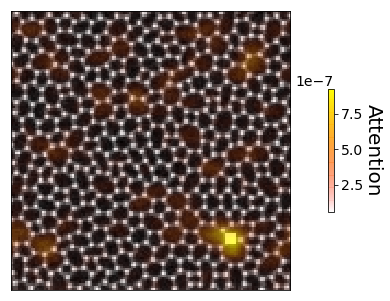

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set(aspect=1)
ax.matshow(array_lattice_bb[:, :, 0], cmap="Greys_r")
c = ax.matshow(mean_gc_heatmap.reshape((128,128,1))[:, :, 0], cmap=make_transparent_cmap(plt.cm.autumn, alpha_max=0.7))
cbar = fig.colorbar(c, shrink = 0.3, pad=0.1)
#cbar.ax.set_ylabel('Attention', rotation=270)
cbar.set_label('Attention', labelpad=20, rotation=270, size=20)
plt.tight_layout()
ax.set_xticks([])
ax.set_yticks([])